<h1> Referrence from Kaggle Competition to be in top 10% </h1>

DMatrix is an internal data structure that is used by XGBoost, which is optimized for both memory efficiency and training speed. You can construct DMatrix from multiple different sources of data.





**Referrence**

1. https://ml.dask.org/modules/generated/dask_ml.xgboost.XGBRegressor.html
2. https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
3. https://stackoverflow.com/questions/61471765/xgboost-what-data-to-use-in-the-watchlist
4. https://www.kaggle.com/mtinti/xgb-1110-from-vladimir-iglovikov-and-tilii7

In [ ]:
## Auto-time calculator 

!pip install ipython-autotime
%load_ext autotime

In [ ]:
## Importing required libraries

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

time: 778 ms


In [ ]:
### Connecting to Google Drive to access files ( Train and Test Data )

from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Applied AI Course/Assignments/23. Self Case Study 1


Mounted at /content/drive
/content/drive/My Drive/Applied AI Course/Assignments/23. Self Case Study 1
time: 20.3 s


<h1> Hyper Parameter Tuning </h1>

In [ ]:
gridsearch_params = [
    (max_depth,subsample)
    for max_depth in range(4,18,4)
	for subsample in [n/10 for n in range(2,12,2)]
]
params = {}

time: 1.54 ms


In [ ]:
"""
Reading Train and Test data
"""
Train_Data = pd.read_csv('train.csv')
Test_Data = pd.read_csv('test.csv')
Submission_Id = Test_Data['id']

r,c = Train_Data.shape   # r -> rows and c  --> columns # 188318 and 130

y = np.log(Train_Data['loss'] + 200)

Train_Data.drop(['id','loss'], axis=1, inplace=True)
Test_Data.drop(['id'], axis=1, inplace=True)

Train_Test = pd.concat((Train_Data, Test_Data)).reset_index(drop=True)

def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(preds), np.exp(labels))

if __name__ == '__main__':
  cat_feature = [n for n in Train_Data.columns if n.startswith('cat')]
  for column in cat_feature:
    if Train_Data[column].nunique() != Test_Data[column].nunique():
      Unique_classes_Train = set(Train_Data[column].unique())
      Unique_classes_Test = set(Test_Data[column].unique())
      missing_train = Unique_classes_Train.difference(Unique_classes_Test)           # set_A.difference(set_B) for (A - B)
      missing_test =  Unique_classes_Test.difference(Unique_classes_Train)

      All_misisng = missing_train.union(missing_test)

      # Replace all misisng categories with a common category instead of removing. 
      def missing_common(x):
        if x in All_misisng:
          return np.nan
        return x
      
      Train_Test[column] = Train_Test[column].apply(lambda x: missing_common(x), 1)   # Axis 1 :: columns
    
    Train_Test[column] = pd.factorize(Train_Test[column].values, sort=True)[0]

  Train_Data_final = Train_Test.iloc[:r, :]
  Test_Data_final = Train_Test.iloc[r:, :]  

  min_mae = float("Inf")
  best_params = None 

  xgtrain = xgb.DMatrix(Train_Data_final, label=y)

  for max_depth, subsample in gridsearch_params:
    print("CV with max_depth={}, subsample={}".format(max_depth, subsample))

    params['max_depth'] = max_depth
    params['subsample'] = subsample

    cv_results = xgb.cv(
        params,
        xgtrain,
        1000,
        seed=42,
        nfold=3,
        metrics={'mae'},
        early_stopping_rounds=10
    )

    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth, subsample)

    print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with max_depth=4, subsample=0.2
	MAE 0.38658400000000004 for 999 rounds
Best params: 4, 0.2, MAE: 0.38658400000000004
CV with max_depth=4, subsample=0.4
	MAE 0.386149 for 999 rounds
Best params: 4, 0.4, MAE: 0.386149
CV with max_depth=4, subsample=0.6
	MAE 0.385971 for 999 rounds
Best params: 4, 0.6, MAE: 0.385971
CV with max_depth=4, subsample=0.8
	MAE 0.3860726666666667 for 999 rounds
Best params: 4, 0.6, MAE: 0.385971
CV with max_depth=4, subsample=1.0
	MAE 0.38611900000000005 for 999 rounds
Best params: 4, 0.6, MAE: 0.385971
CV with max_depth=8, subsample=0.2
	MAE 0.37776566666666667 for 999 rounds
Best params: 8, 0.2, MAE: 0.37776566666666667
CV with max_depth=8, subsample=0.4
	MAE 0.37622133333333335 for 999 rounds
Best params: 8, 0.4, MAE: 0.37622133333333335
CV with max_depth=8, subsample=0.6
	MAE 0.3755726666666666 for 999 rounds
Best params: 8, 0.6, MAE: 0.3755726666666666
CV with max_depth=8, subsample=0.8
	MAE 0.375323 for 999 rounds
Best params: 8, 0.8, MAE: 0.375323
CV

In [ ]:
gridsearch_params = [
    (alpha,gamma)
    for alpha in [1/n for n in range(1,3)]
	for gamma in [1/n for n in range(1,3)]
]

params = {}

time: 2.09 ms


In [ ]:
for alpha, gamma in gridsearch_params:
  print("CV with alpha={}, gamma={}".format(alpha, gamma))
  params['max_depth'] = 12
  params['subsample'] = 0.8
  params['alpha'] = alpha
  params['gamma'] = gamma
  
  cv_results = xgb.cv(
        params,
        xgtrain,
        1000,
        seed=42,
        nfold=3,
        metrics={'mae'},
        early_stopping_rounds=10
    )
  mean_mae = cv_results['test-mae-mean'].min()
  boost_rounds = cv_results['test-mae-mean'].argmin()
  print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
  if mean_mae < min_mae:
    min_mae = mean_mae
    best_params = (alpha, gamma)
    
  print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with alpha=1.0, gamma=1.0
	MAE 0.428306 for 24 rounds
Best params: 1.0, 1.0, MAE: 0.428306
CV with alpha=1.0, gamma=0.5
	MAE 0.4303866666666667 for 20 rounds
Best params: 1.0, 1.0, MAE: 0.428306
CV with alpha=0.5, gamma=1.0
	MAE 0.42898966666666666 for 24 rounds
Best params: 1.0, 1.0, MAE: 0.428306
CV with alpha=0.5, gamma=0.5
	MAE 0.43154933333333334 for 22 rounds
Best params: 1.0, 1.0, MAE: 0.428306
time: 2min 9s


In [ ]:
gridsearch_params = [
    (colsample_bytree,eta)
    for colsample_bytree in [1/n for n in range(1,3)]
	  for eta in [1/(10**n) for n in range(1,4)]
]

params = {}

for colsample_bytree, eta in gridsearch_params:
  print("CV with colsample_bytree={}, eta={}".format(colsample_bytree, eta))
  params['max_depth'] = 12
  params['subsample'] = 0.8
  params['alpha'] = 1
  params['gamma'] = 1
  params['colsample_bytree'] = colsample_bytree
  params['eta'] = eta
  
  cv_results = xgb.cv(
        params,
        xgtrain,
        1000,
        seed=42,
        nfold=3,
        metrics={'mae'},
        early_stopping_rounds=10
    )
  mean_mae = cv_results['test-mae-mean'].min()
  boost_rounds = cv_results['test-mae-mean'].argmin()
  print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
  if mean_mae < min_mae:
    min_mae = mean_mae
    best_params = (colsample_bytree, eta)
    
  print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

CV with colsample_bytree=1.0, eta=0.1
	MAE 0.41825033333333334 for 113 rounds
Best params: 1.0, 0.1, MAE: 0.41825033333333334
CV with colsample_bytree=1.0, eta=0.01
	MAE 0.415004 for 999 rounds
Best params: 1.0, 0.01, MAE: 0.415004
CV with colsample_bytree=1.0, eta=0.001
	MAE 2.6447746666666667 for 999 rounds
Best params: 1.0, 0.01, MAE: 0.415004
CV with colsample_bytree=0.5, eta=0.1
	MAE 0.4176849999999999 for 126 rounds
Best params: 1.0, 0.01, MAE: 0.415004
CV with colsample_bytree=0.5, eta=0.01
	MAE 0.41441100000000003 for 999 rounds
Best params: 0.5, 0.01, MAE: 0.41441100000000003
CV with colsample_bytree=0.5, eta=0.001
	MAE 2.6444276666666666 for 999 rounds
Best params: 0.5, 0.01, MAE: 0.41441100000000003
time: 22min 51s


<h1> Final Code </h1>

In [ ]:
"""
Reading Train and Test data
"""
# Reading training data
Train_Data = pd.read_csv('train.csv')
## Reading test data
Test_Data = pd.read_csv('test.csv')
# saving ID for submission file.
Submission_Id = Test_Data['id']

r,c = Train_Data.shape   # r -> rows and c  --> columns # 188318 and 130

#Reading y value.
y = np.log(Train_Data['loss'] + 200) 

# Removing ID and LOSS columns from Traina nd ID from Test
Train_Data.drop(['id','loss'], axis=1, inplace=True)
Test_Data.drop(['id'], axis=1, inplace=True)

## Concatinating Train and Test
Train_Test = pd.concat((Train_Data, Test_Data)).reset_index(drop=True)

## Custom metrice : Error calculation
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(preds), np.exp(labels))

## main funtion
if __name__ == '__main__':
  # Filtering categorical dfeatures.
  cat_feature = [n for n in Train_Data.columns if n.startswith('cat')]
  ## Looping through categorical features. 
  for column in cat_feature:
    # For every column , validating the Train classes and test classes equal or not. 
    if Train_Data[column].nunique() != Test_Data[column].nunique():
      ## Reading only unique train class from eac column 
      Unique_classes_Train = set(Train_Data[column].unique())
      ## Reading only unique test class from eac column 
      Unique_classes_Test = set(Test_Data[column].unique())
      ## Classes available in train but not in test 
      missing_train = Unique_classes_Train.difference(Unique_classes_Test)           # set_A.difference(set_B) for (A - B)
      ## Classes available in test but not in train 
      missing_test =  Unique_classes_Test.difference(Unique_classes_Train)
      ## Reading all missing classes from train and test
      All_misisng = missing_train.union(missing_test)

      # Replace all misisng categories with a common category instead of removing. 
      def missing_common(x):
        if x in All_misisng:
          return np.nan
        return x
      
      ## missing classes is replaced with null values. 
      ## Pandas factorize replaces all categorical variables by integers, and NaN with -1, and xgboost treats them as the same category.
      Train_Test[column] = Train_Test[column].apply(lambda x: missing_common(x), 1)   # Axis 1 :: columns
    
    ## factorize the categorical features. 
    Train_Test[column] = pd.factorize(Train_Test[column].values, sort=True)[0]
  
  ## Separating the Train and Test data.
  Train_Data_final = Train_Test.iloc[:r, :]
  Test_Data_final = Train_Test.iloc[r:, :]
  
  ## K-fold cross validation. 
  kf = KFold(n_splits=3)
  prediction = np.zeros(Submission_Id.shape)
  
  ## Train data divided into 3 folds with 2 for training and 1 for testing 
  for train_index, test_index in kf.split(Train_Data_final):
    X_train, X_test = Train_Data_final.iloc[train_index], Train_Data_final.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    params = {
            'min_child_weight': 1,             # Default valaue
            'eta': 0.01,                       # Hyper parameter
            'colsample_bytree': 0.5,            # Hyper parameter
            'max_depth': 12,                    # Hyper parameter
            'subsample': 0.8,                   # Hyper parameter
            'alpha': 1,                         # Hyper parameter
            'gamma': 1,                         # Hyper parameter
            'silent': 1,
            'verbose_eval': True,
            'seed': 2020,
        }

     ## Converting DataFrame to Dmatrix, DMatrix is an internal data structure that is used by XGBoost, which is optimized for both memory efficiency and training speed.
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    xgtest  = xgb.DMatrix(X_test, label=y_test)
    xgtest_final = xgb.DMatrix(Test_Data_final)

    # watchlist allows us to monitor the evaluation result on all data in the list. print("Train xgboost using xgb.train with watchlist")
    watchlist = [(xgtrain, 'train'), (xgtest, 'eval')]
    
    # Training the model with Hyper parameters and 2000 is boosting rounds. 
    model = xgb.train(params, xgtrain, 2000, watchlist, feval=evalerror, early_stopping_rounds=100) 
    prediction += np.exp(model.predict(xgtest_final)) - 200
  
  prediction = prediction/3
  submission = pd.DataFrame()
  submission['id'] = Submission_Id    
  submission['loss'] = prediction
  submission.to_csv('score.csv', index=False)

Streaming output truncated to the last 5000 lines.
[1007]	train-rmse:0.424366	eval-rmse:0.476429	train-mae:1010.42	eval-mae:1141.18
[1008]	train-rmse:0.424341	eval-rmse:0.476423	train-mae:1010.34	eval-mae:1141.17
[1009]	train-rmse:0.424322	eval-rmse:0.476419	train-mae:1010.3	eval-mae:1141.16
[1010]	train-rmse:0.424283	eval-rmse:0.476417	train-mae:1010.2	eval-mae:1141.15
[1011]	train-rmse:0.424254	eval-rmse:0.476411	train-mae:1010.13	eval-mae:1141.13
[1012]	train-rmse:0.424186	eval-rmse:0.476404	train-mae:1009.95	eval-mae:1141.11
[1013]	train-rmse:0.424151	eval-rmse:0.476401	train-mae:1009.86	eval-mae:1141.1
[1014]	train-rmse:0.4241	eval-rmse:0.476394	train-mae:1009.73	eval-mae:1141.09
[1015]	train-rmse:0.424083	eval-rmse:0.476393	train-mae:1009.69	eval-mae:1141.08
[1016]	train-rmse:0.424064	eval-rmse:0.476391	train-mae:1009.64	eval-mae:1141.07
[1017]	train-rmse:0.424032	eval-rmse:0.476388	train-mae:1009.54	eval-mae:1141.06
[1018]	train-rmse:0.423999	eval-rmse:0.476386	train-mae:1009.46

In [ ]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

time: 474 ms


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 261.PNG to 261.PNG
Saving 3045.PNG to 3045.PNG
Saving best_score.PNG to best_score.PNG


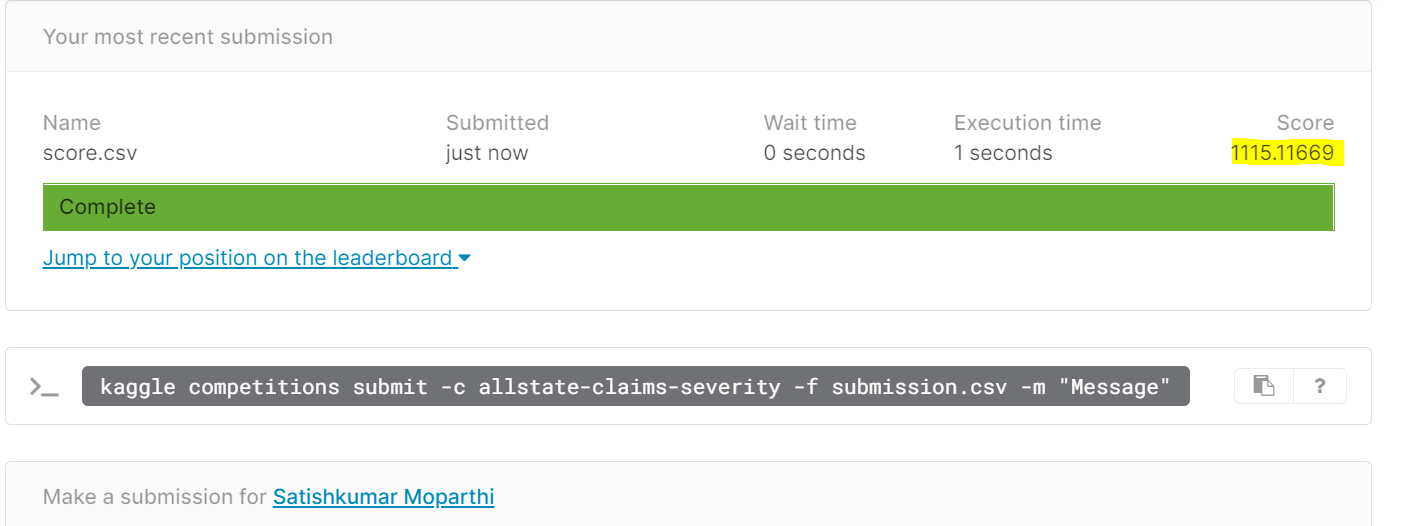

In [ ]:
from IPython.display import Image
Image(filename='best_score.PNG')

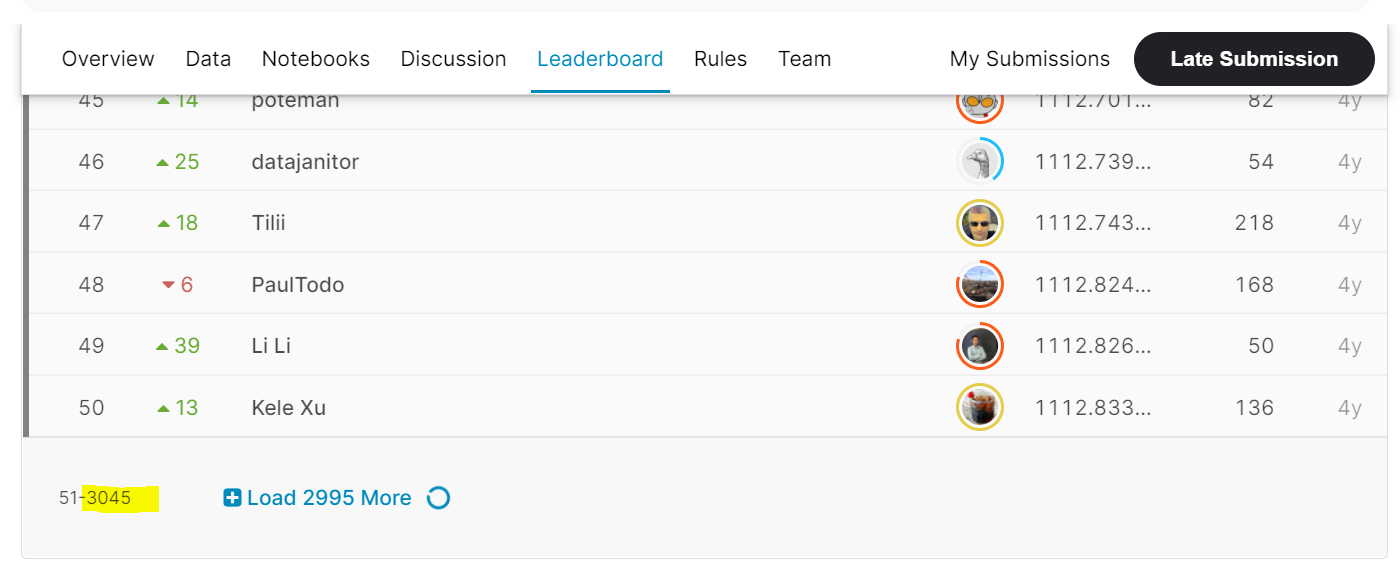

In [ ]:
Image(filename='3045.PNG')

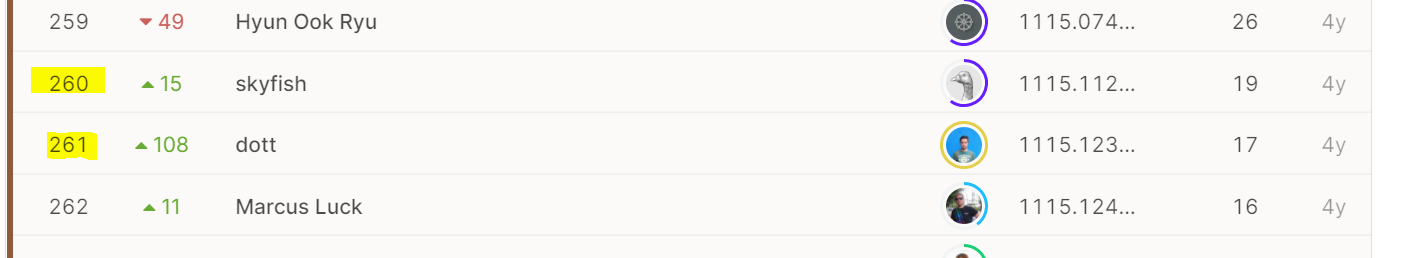

In [ ]:
Image(filename='261.PNG')

In [ ]:
Total_entries = 3045
Best_score_position = 261
my_percentage = (Best_score_position/Total_entries)*100
print(my_percentage)

8.571428571428571
